In [1]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
#img = cv2.imread('test_intersection.png')
img = cv2.imread('../images/intersection3.png')
#img = cv2.imread('test3.png')
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

#hsv = cv2.GaussianBlur(hsv, (51, 51), 0)

lower_bound = np.array([0, 0, 50]) # H=0, S=0, V=50
upper_bound = np.array([180, 50, 150])

# Create a mask based on this range
mask = cv2.inRange(hsv, lower_bound, upper_bound)

#sobel_horizontal = cv2.Sobel(img, cv2.CV_64F, dx=0, dy=1, ksize=3)
#sobel_horizontal = cv2.convertScaleAbs(sobel_horizontal)

masked_img = cv2.bitwise_and(img, img, mask=mask)

masked_img = cv2.GaussianBlur(masked_img, (15, 15), 0)

edges = cv2.Canny(masked_img, 50, 150, apertureSize=3)

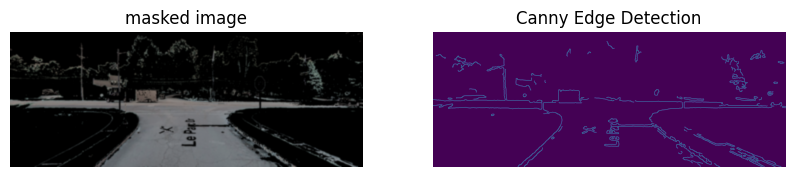

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(masked_img)
ax[0].set_title("masked image")
ax[0].axis("off")

ax[1].imshow(edges)
ax[1].set_title("Canny Edge Detection")
ax[1].axis("off")

plt.show()
plt.close()

In [5]:
lines = cv2.HoughLinesP(
    edges, 
    rho=1,         # distance resolution in pixels
    theta=np.pi/180, # angle resolution in radians
    threshold=50,  # minimum number of votes (intersections in accumulator)
    minLineLength=50,  # minimum length of a line in pixels
    maxLineGap=10    # maximum gap between segments to consider them the same line
)

print(len(lines))
#print(lines)

37


Show all detected edges

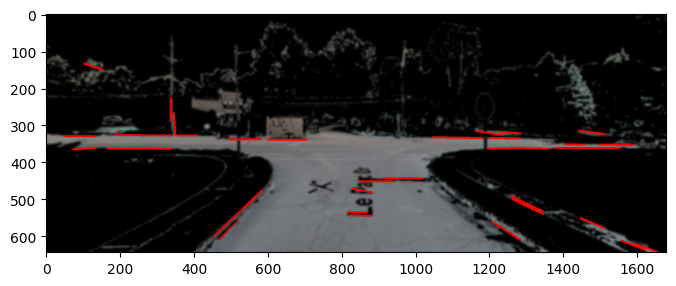

In [6]:
line_img = masked_img.copy()

tot_y = 0
vals = 0
max_x = -math.inf
min_x = math.inf

for (x1, y1, x2, y2) in np.squeeze(lines):
    cv2.line(line_img, (x1, y1), (x2, y2), (255, 0, 0), 3)

'''
cv2.imshow("Detected Horizontal Lines", line_img)
cv2.waitKey(0)
cv2.destroyAllWindows()
'''

plt.figure(figsize=(8, 6))
plt.imshow(line_img)
plt.show()

Create the final intersection start proposal

0.0348906913687919
[ 9 18 22 34 16 32 13  0  6  5  4  3 10 12 24  1 33  2  7 31 23]
[[1195  364 1278  362]
 [ 496  339  582  338]
 [ 257  328  341  328]
 [ 818  536  870  536]
 [ 601  340  706  340]
 [ 290  364  340  364]
 [  50  330  133  330]
 [1378  362 1553  362]
 [ 187  327  256  327]
 [ 849  452  942  452]
 [ 355  328  410  328]
 [ 164  363  309  363]
 [ 915  444 1021  444]
 [1499  353 1590  354]
 [1198  335 1284  336]
 [1046  333 1182  335]
 [ 823  544  882  545]
 [1406  352 1460  353]
 [1279  362 1363  364]
 [1227  318 1285  322]
 [1442  315 1512  324]]
[ True  True  True False  True  True  True  True  True False  True  True
 False  True  True  True False  True  True  True  True]
[[1236.5  363. ]
 [ 539.   338.5]
 [ 299.   328. ]
 [ 653.5  340. ]
 [ 315.   364. ]
 [  91.5  330. ]
 [1465.5  362. ]
 [ 221.5  327. ]
 [ 382.5  328. ]
 [ 236.5  363. ]
 [1544.5  353.5]
 [1241.   335.5]
 [1114.   334. ]
 [1433.   352.5]
 [1321.   363. ]
 [1256.   320. ]
 [1477.   319.5]]


C:\Users\Aaron\AppData\Local\Temp\ipykernel_55608\2096298553.py:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pt1 = (int(x0_refined - vx_refined * t), int(y0_refined - vy_refined * t))
C:\Users\Aaron\AppData\Local\Temp\ipykernel_55608\2096298553.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pt2 = (int(x0_refined + vx_refined * t), int(y0_refined + vy_refined * t))


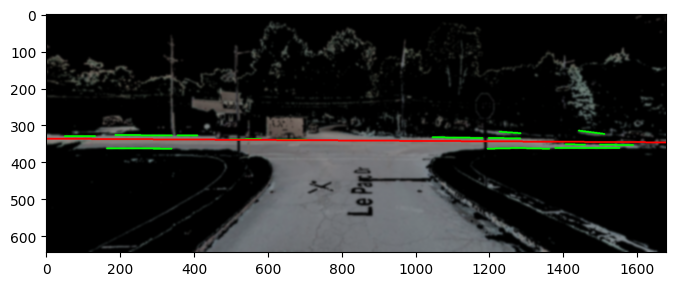

In [ ]:
line_img = masked_img.copy()

tot_y = 0
vals = 0
max_x = -math.inf
min_x = math.inf
slopes = []

segs = np.squeeze(lines)
segs = segs[[x1 != x2 for (x1, _, x2, _) in segs]]

for (x1, y1, x2, y2) in segs:
    # keep only horizontalish lines
    slopes.append(math.atan((y2 - y1) / (x2 - x1)))

inds = np.argsort(slopes)

slopes = sorted(slopes)
slopes = np.array(slopes)
avg_slope = sum(slopes[(int) (len(slopes) * 0.25):(int) (len(slopes) * 0.75)]) / len(slopes[(int) (len(slopes) * 0.25):(int) (len(slopes) * 0.75)])

inds = inds[abs(slopes - avg_slope) < 0.1]
midpoints = [[(x2 + x1) / 2, (y1 + y2) / 2] for (x1, y1, x2, y2) in segs[inds]]

midpoints = np.array(midpoints, dtype=np.float32)

vx, vy, x0, y0 = cv2.fitLine(midpoints, cv2.DIST_L2, 0, 0.01, 0.01)

# Compute perpendicular distances to the fitted line
distances = []
for (mx, my) in midpoints:
    # Distance from point (mx, my) to line (vx, vy, x0, y0)
    numerator = abs(vy * (mx - x0) - vx * (my - y0))
    denominator = np.sqrt(vy**2 + vx**2)
    distances.append(numerator / denominator)

# Set a threshold (e.g., 5 pixels) to classify inliers
threshold = 1.5 * (sum(distances) / len(distances))
distances = np.array(distances, dtype=np.float32)

inlier_mask = distances < threshold

vx_refined, vy_refined, x0_refined, y0_refined = cv2.fitLine(midpoints[inlier_mask.T[0]], cv2.DIST_L2, 0, 0.01, 0.01)

for (x1, y1, x2, y2) in segs[inds][inlier_mask.T[0]]:
    cv2.line(line_img, (x1, y1), (x2, y2), (0, 255, 0), 3)

t = 1000  # Extend line length
pt1 = (int(x0_refined - vx_refined * t), int(y0_refined - vy_refined * t))
pt2 = (int(x0_refined + vx_refined * t), int(y0_refined + vy_refined * t))
cv2.line(line_img, pt1, pt2, (255, 0, 0), 3)

"""
for (x1, y1, x2, y2) in np.squeeze(lines)[inds[(int) (len(slopes) * 0.25):(int) (len(slopes) * 0.75)]]:
    if x2 !=x1 and (abs(math.atan((y2 - y1) / (x2 - x1))) < 0.1):
        # show filtered lines
        cv2.line(line_img, (x1, y1), (x2, y2), (0, 255, 0), 3)

        # get approx regression through the horizontal lines
        tot_y += y2
        tot_y += y1
        vals += 2
        max_x = max(max_x, x1, x2)
        min_x = min(min_x, x1, x2)

cv2.line(line_img, (min_x, tot_y // vals), (max_x, tot_y // vals), (255, 0, 0), 3)
"""


'''
cv2.imshow("Detected Horizontal Lines", line_img)
cv2.waitKey(0)
cv2.destroyAllWindows()
'''

plt.figure(figsize=(8, 6))
plt.imshow(line_img)
plt.show()